In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\titanic.csv")

In [4]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [6]:
print(df.describe(include='all'))

        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare 

In [7]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
print(f"Jumlah duplikat: {df.duplicated().sum()}")

Jumlah duplikat: 0


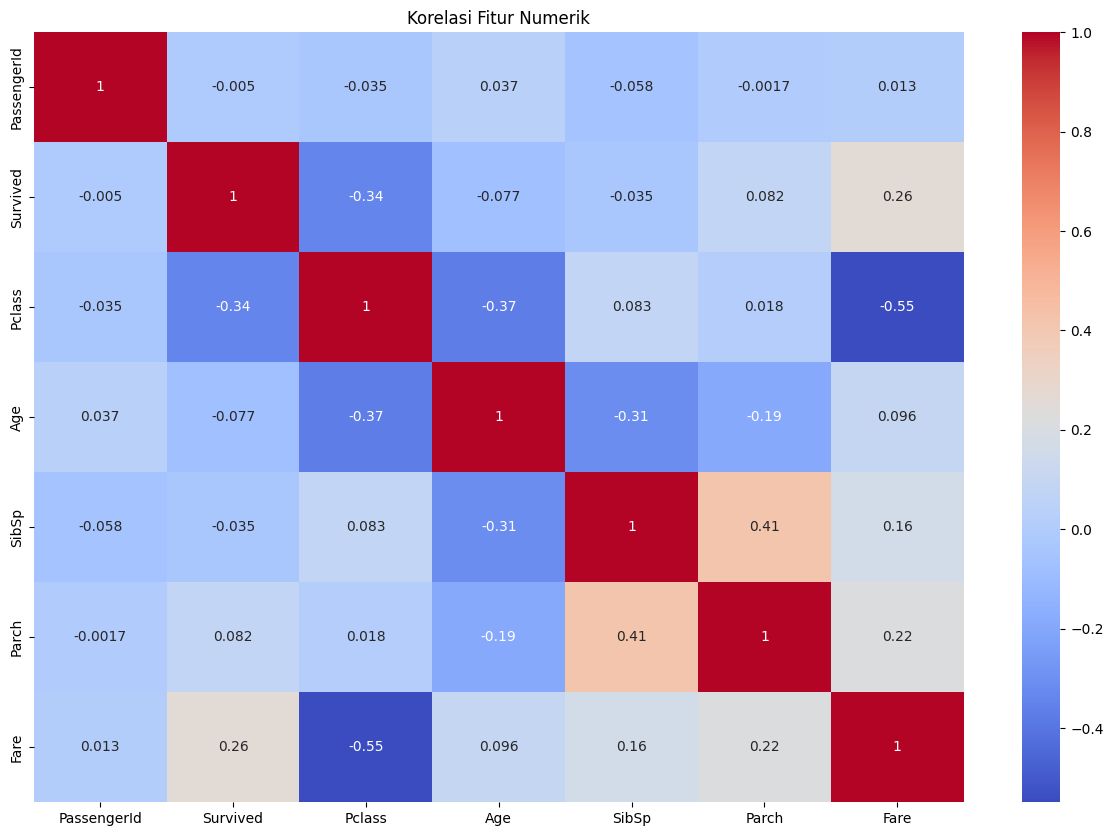

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Fitur Numerik')
plt.show()

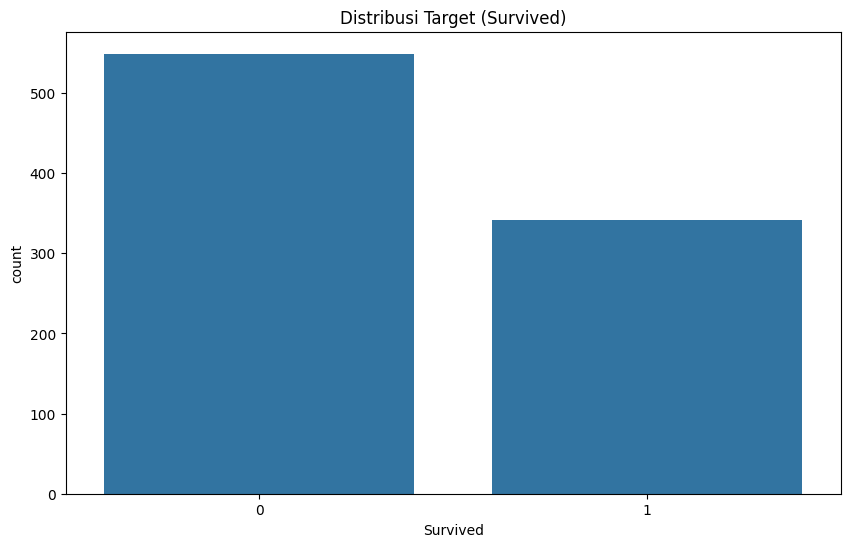

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='Survived', data=df)
plt.title('Distribusi Target (Survived)')
plt.show()

In [11]:
age_median = df['Age'].median()
df['Age'] = df['Age'].fillna(age_median)

In [12]:
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(embarked_mode)

In [13]:
df = df.drop('Cabin', axis=1)

In [14]:
df = df.dropna()

In [15]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                  'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [16]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [17]:
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [18]:
bins = [0, 12, 18, 30, 50, 100]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

In [19]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [20]:
print(detect_outliers(df, 'Fare'))

     PassengerId  Survived  Pclass  \
1              2         1       1   
27            28         0       1   
31            32         1       1   
34            35         0       1   
52            53         1       1   
..           ...       ...     ...   
846          847         0       3   
849          850         1       1   
856          857         1       1   
863          864         0       3   
879          880         1       1   

                                                  Name     Sex   Age  SibSp  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                      Fortune, Mr. Charles Alexander    male  19.0      3   
31      Spencer, Mrs. William Augustus (Marie Eugenie)  female  28.0      1   
34                             Meyer, Mr. Edgar Joseph    male  28.0      1   
52            Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   
..                                                 ...     ...   ... 

In [21]:
df['Fare'] = stats.mstats.winsorize(df['Fare'], limits=[0.05, 0.05])

In [22]:
label_enc = LabelEncoder()
df['Sex'] = label_enc.fit_transform(df['Sex'])
df['Embarked'] = label_enc.fit_transform(df['Embarked'])

In [23]:
df = pd.get_dummies(df, columns=['Title', 'AgeGroup'], drop_first=True)

In [24]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Age', 'SibSp', 'Parch'], axis=1)

In [25]:
X = df.drop('Survived', axis=1)
y = df['Survived']
selector = SelectKBest(chi2, k=8)
X_new = selector.fit_transform(X, y)

In [26]:
numerical_features = ['Fare', 'FamilySize']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [27]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_new)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
preprocessed_df = pd.DataFrame(X_new)
preprocessed_df['Survived'] = y.values
preprocessed_df.to_csv('titanic_preprocessed.csv', index=False)

In [30]:
print("Shape akhir data:", X_new.shape)

Shape akhir data: (891, 8)


In [ ]:
numerical_cols = ['Age', 'Fare']


knn_imputer = KNNImputer(n_neighbors=5)


df[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])

print("\n================== HASIL KNN IMPUTATION ==================")
print(df[numerical_cols].isnull().sum())

In [ ]:
numerical_features = ['Age', 'Fare']
categorical_features = ['Embarked', 'Sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features) 
    ])

X_transformed = preprocessor.fit_transform(df)

print("\n================== HASIL COLUMN TRANSFORMER ==================")
print(X_transformed[:5]) 

In [ ]:
preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),               
    ('pca', PCA(n_components=2))                  
])

X_numerical = df[['Age', 'Fare']]
X_transformed = preprocessing_pipeline.fit_transform(X_numerical)

print("\n================== HASIL PIPELINE ==================")
print(X_transformed[:5])

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_numerical)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Survived'], cmap='viridis')
plt.title('t-SNE Visualisasi Data Titanic')
plt.colorbar(label='Survived')
plt.show()